In [2]:
import jax 
import jax.numpy as jnp
import immrax as irx
from time import time

In [3]:
eps = 0.0001

class VanDerPol (irx.System) : 
    def __init__ (self) :
        self.evolution = 'continuous'
        self.xlen = 2

    def f (self, t, x) :
        mu = 0.25
        return jnp.array([
            x[1],
            mu*(1 - x[0]**2)*x[1] - x[0]
        ])

sys = VanDerPol()


In [4]:
solver = 'tsit5'
dt = 0.05

x0 = jnp.array([-2, 0.])
R = 0.25
Y = 100.
ix0 = irx.icentpert(x0, R*jnp.array([.5, .5/Y]))
pt0 = irx.Polytope.from_interval(ix0)
Hp0 = jnp.eye(2)
N0 = jnp.zeros((0,2))
perm = irx.Permutation((0, 2, 1))

t0 = 0.
tf = (2.2)*jnp.pi
dt = tf / 500
tr = jnp.pi/2

# Monte Carlo sampling---uniform plus vertices 
xtest0 = jnp.vstack((
    pt0.get_vertices(),
    irx.utils.gen_ics(ix0, 50)
))

print(ix0)

[-2.125e+00 -1.250e-03] <= x <= [-1.875e+00  1.250e-03]


In [5]:
@jax.jit
def jit_reach_set (t0, tf, pt0, Hp0, N0, kap) :
    embsys = irx.AdjointEmbedding(sys, Hp0, N0, kap, permutation=perm)
    return embsys.compute_reachset(t0, tf, pt0, dt=dt, solver=solver)

# JIT Compile
jit_t0 = time()
_ = jax.block_until_ready(jit_reach_set(0., dt, pt0, Hp0, N0, .01, ))
jit_tf = time()
print(f'JIT compiled in {jit_tf - jit_t0:.5f} seconds')


JIT compiled in 2.06928 seconds


In [6]:
# tf = 2.5*jnp.pi
N = 10
RS, times = irx.utils.run_times(N, jit_reach_set, t0, tf, pt0, Hp0, N0, 1.e-1)
print(f'Computed Reachable Set in {jnp.mean(times):.5f} ± {jnp.std(times):.5f} over {N} runs')

Computed Reachable Set in 0.00670 \pm 0.00066 over 10 runs


<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_66323/504840867.py:4: SyntaxWarning: invalid escape sequence '\p'
  print(f'Computed Reachable Set in {jnp.mean(times):.5f} \pm {jnp.std(times):.5f} over {N} runs')


In [7]:
# Post-processing

tfinite = jnp.where(jnp.isfinite(RS.ts))
lenT = len(tfinite[0])
print(lenT)
yy = RS.ys[0]
auxx = RS.ys[1]
tt = RS.ts[tfinite]

def mc_sim (mc_x0) :
    traj = sys.compute_trajectory(t0, tf, mc_x0, dt=dt, solver=solver)
    return traj.ys[tfinite]

mc_res = jax.vmap(mc_sim)(xtest0)
print(mc_res.shape)

501
(54, 501, 2)


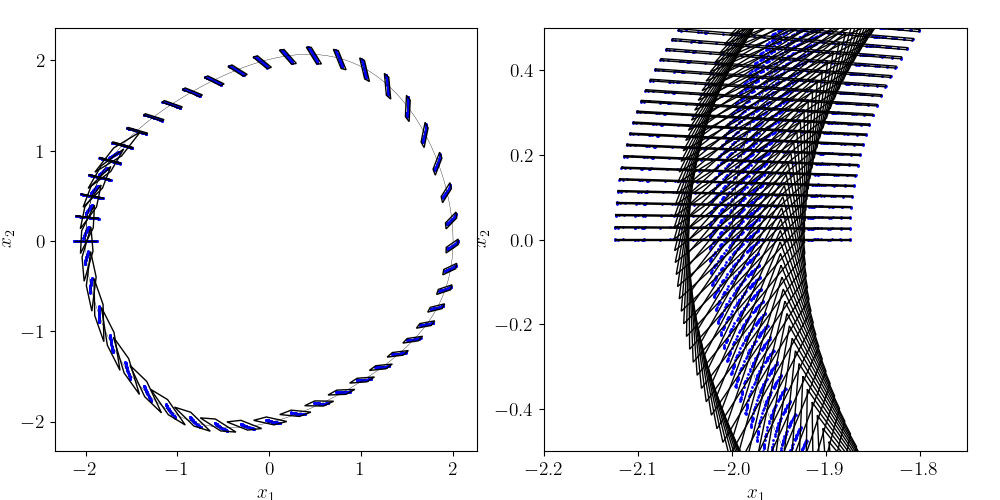

In [8]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as onp
from pypoman import project_polytope

start = 0
plot_every = 10
PRINT = False

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": 14
})
fig, axs = plt.subplots(1,2,figsize=(10, 5))

fig.tight_layout()

for ax in axs :
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

for n in range (len(mc_res)) :
    axs[0].scatter(mc_res[n,::plot_every,0], mc_res[n,::plot_every,1], s=1, c='b')
    axs[1].scatter(mc_res[n,:,0], mc_res[n,:,1], s=1, c='b')

# Nominal trajectory
for ax in axs :
    ax.plot(yy.ox[:,0], yy.ox[:,1], c='black', lw=0.25)

for i in range (start, len(tfinite[0])) :
    if PRINT :
        print(f'\n{i}')
        print('ox: ', yy.ox[i])
        print('alpha: ', yy.alpha[i,:])
        print('y: ', yy.y[i,:])
        print('alpha_p: ', auxx[0][i])
        print('N: ', auxx[1][i])
        print('alpha_p@alpha: ', jnp.dot(auxx[0][i], yy.alpha[i,:]))
        print('N@alpha: ', jnp.dot(auxx[1][i], yy.alpha[i,:]))
    dsi = pt0.__class__.from_parametope(irx.hParametope(yy.ox[i], yy.alpha[i,:], yy.y[i,:]))
    try:
        if i % plot_every == 0 :
            dsi.plot_projection(axs[0], color='black')
        dsi.plot_projection(axs[1], color='black')

    except Exception as e:
        print_i = i
        print('\n', e, i)
        print(dsi.ox)
        # print(''jax.jacfwd(sys.f, 1)(0., dsi.ox))
        print('J: ', jax.jacfwd(sys.f, 1)(0., yy.ox[print_i]))
        print('alpha: ', yy.alpha[print_i])
        print('Hp: ', auxx[0][print_i])
        print('N: ', auxx[1][print_i])
        print('y: ', yy.y[print_i])
        break

axs[1].set_xlim(-2.2, -1.75)
axs[1].set_ylim(-0.5, 0.5)

fig.savefig('figures/VanDerPol.pdf')
fig.savefig('figures/VanDerPol.svg')
fig.savefig('figures/VanDerPol.png', dpi=300)